### First set number of cores on machine to use and SSID number to analyse, then run all

In [1]:
# setting variables

cores = 3 # enter the number of cores to use here, in place of x
SSIDno = 47797057 # enter the SSID number to model as an int here, in place of xxxxxxxx
iters = 38 # enter the number of randomised search iterations here 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches
#import matplotlib.font_manager as fm
import matplotlib
import autotime
%matplotlib inline
%load_ext autotime
#import seaborn as sns
import statsmodels as stm
import statsmodels.formula.api as sm

from sklearn import metrics
from sklearn.linear_model import LinearRegression as LinR

from sklearn.ensemble import GradientBoostingRegressor as GBR

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV as RSCV

from sklearn.metrics.scorer import make_scorer
from scipy import stats
from scipy.stats import randint

#from sklearn.tree import export_graphviz
#from IPython.display import Image

## 1. Data processing stage

First, select route files to input based on SSIDno to analyse

### 1a Inputting data and creating dataframe for SSIDno

In [3]:
# Read in stop_times.txt and trips.txt files from NTA data
stop_times_2012 = pd.read_csv('stop_times.txt')
trips_2012 = pd.read_csv('trips.txt')

# Merge by trip_id
merge = pd.merge(stop_times_2012, trips_2012, on='trip_id', how='outer')

# Keep only necessary columns
merge.drop(['arrival_time','departure_time','pickup_type','drop_off_type','service_id','shape_dist_traveled'], axis=1, inplace=True)

# Transform trip_id to route and stop_id to StopID
merge['route_short'] = merge['trip_id'].apply(lambda x: x[x.index('-')+1:])
merge['route_short'] = merge['route_short'].apply(lambda x: x[: x.index('-')])
merge['route_short'] = merge['route_short'].apply(lambda x: str(x).zfill(4))
merge['StopID'] = merge['stop_id'].apply(lambda x: x[-4:])

# Find StopID and the sequence of that shape_id
gb = merge.groupby(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'])
gbc = gb.count()
gbc.reset_index(['shape_id', 'route_short', 'direction_id','stop_sequence', 'StopID'], inplace=True)
transit_shapeID_stopID = gbc.drop(['trip_id','stop_id','route_id','trip_headsign'], axis=1)

# create list of pairs of routes and the SSIDs contained within them
ssid = []
for i in range(len(transit_shapeID_stopID.index)-1):
    temp = transit_shapeID_stopID['StopID'].iloc[i] + transit_shapeID_stopID['StopID'].iloc[i+1]
    ssid.append([ transit_shapeID_stopID['route_short'].iloc[i],temp])
    
SSIDnoStr = str(SSIDno).zfill(8)
routes = [x for x in ssid if SSIDnoStr in x[1]]
routes = [item[0] for item in routes]
routes = list(set(routes))

# Reading in the route CSV files for the required SSID

res = pd.read_csv('Route_XXXX_travel_time_csvs/Blank_Route_travel_time.csv')
route_list = routes
for r in route_list:
    df = pd.read_csv('Route_XXXX_travel_time_csvs/Route_%s_travel_time.csv' % r)
    res = pd.concat([df, res], axis=0) 

time: 5.06 s


In [4]:
# create dataframe for SSIDno

res['SSID'] = res['SSID'].astype('category')
ssid_df = res[res.SSID == SSIDno]
ssid_df.reset_index(inplace=True)
ssid_df = ssid_df.drop('index', axis=1)
ssid_df.shape

(3148, 12)

time: 64 ms


In [5]:
JPID_Count = ssid_df.JourneyPatternID.unique().shape[0]
Row_Count = ssid_df.shape[0]
print("There are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

There are 7 unique JPIDs traversing this segment, over the course of 3148 observations.
time: 2 ms


In [6]:
# add leading zeroes to JourneyPatternID

ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.astype('object')
ssid_df.JourneyPatternID = ssid_df.JourneyPatternID.apply(lambda x: str(x).zfill(8))

time: 7 ms


### 1b Adding extra features and altering/dropping existing ones

In [7]:
# adding Xbuses feature - boolean feature indicating whether or not the JourneyPatternID represents an express (X) bus

ssid_df['XBuses'] = ssid_df[ssid_df["JourneyPatternID"].str.find("X") > 0].sum(axis=1) > 0
ssid_df["XBuses"].fillna(False, inplace=True)
ssid_df['XBuses'] = ssid_df['XBuses'].astype('int')

time: 14 ms


In [8]:
# adding JPID_length feature - represents the total number of stops traversed by this JourneyPatternID along its entire route

JPIDL = pd.read_csv('JPID_Length.csv')
JPIDL = JPIDL.drop('Unnamed: 0', axis=1)
ssid_df = pd.merge(left=ssid_df ,right=JPIDL, how='left', left_on='JourneyPatternID', right_on='JourneyPatternID')
ssid_df = ssid_df.dropna()
ssid_df.shape

(3148, 14)

time: 15 ms


In [9]:
# removing non-holiday-period weekends from SchoolHoliday feature to avoid multi-collinearity issues

ssid_df['SchoolHoliday'] = ssid_df['SchoolHoliday'].astype('int')
ssid_df['SchoolHoliday'] = np.where(ssid_df['TimeFrame'].isin(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04', '2013-01-05', '2013-01-06']), 1, 0)

time: 2 ms


In [10]:
# dropping unneeded columns

ssid_df = ssid_df.drop(['SourceStopID', 'DestStopID', 'VehicleJourneyID', 'JourneyPatternID', 'SSID'], axis=1)

# reordering remaining columns

ssid_df = ssid_df[['TravelTime', 'Rain', 'WindSpeed', 'JPID_length', 'XBuses', 'SchoolHoliday', 'Day', 'HourFrame']]

time: 4 ms


In [11]:
# assigning appropriate datatypes where necessary

ssid_df['Day'] = ssid_df['Day'].astype('category')
ssid_df['HourFrame'] = ssid_df['HourFrame'].astype('category')
ssid_df['JPID_length'] = ssid_df['JPID_length'].astype('int')

time: 32 ms


In [12]:
# removing any constant features
# code from: https://stackoverflow.com/questions/20209600/panda-dataframe-remove-constant-column

ssid_df = ssid_df.loc[:,ssid_df.apply(pd.Series.nunique) != 1]

time: 5 ms


In [13]:
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,Day,HourFrame
0,41,0.000000,15.5,48,0,Tuesday,9
1,60,0.000000,15.0,48,0,Tuesday,8
2,43,0.000000,15.5,48,0,Tuesday,16
3,41,0.000000,16.0,48,0,Tuesday,19
4,39,0.000000,14.0,48,0,Tuesday,17
5,41,0.000000,15.5,48,0,Tuesday,9
6,59,0.000000,16.5,48,0,Tuesday,15
7,80,0.000000,14.0,48,0,Tuesday,18
8,40,0.000000,15.0,48,0,Tuesday,20
9,37,0.000000,14.0,48,0,Tuesday,21


time: 23 ms


## 1c. Dropping Outliers

#### Visualising range of travel-time data first

Histiogram of values (x-axis is number of seconds)

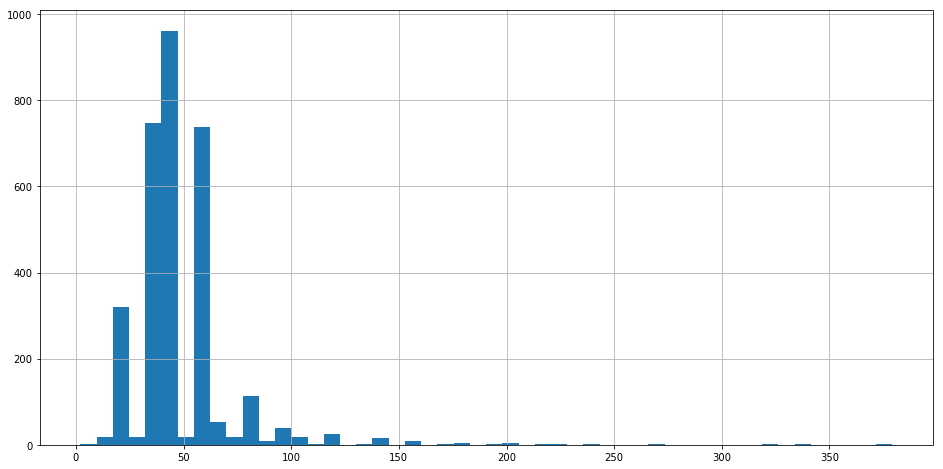

time: 220 ms


In [14]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

Boxplot to check for outliers

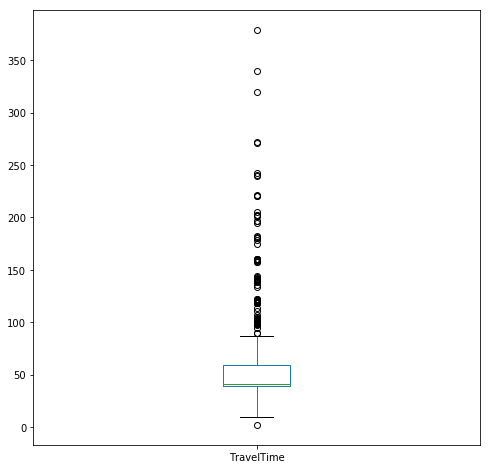

time: 134 ms


In [15]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

In [16]:
# Checking stats for TravelTime

ssid_df.TravelTime.describe()

count    3148.000000
mean       48.778907
std        25.506899
min         2.000000
25%        39.000000
50%        41.000000
75%        59.000000
max       379.000000
Name: TravelTime, dtype: float64

time: 6 ms


Dropping outliers

In [17]:
# loading table of minimum times to traverse segments at 65kmph

find_lb = pd.read_csv('use_speed_and_distance_get_outlier_bound.csv')

# extracting value for this segment, to use as lower bound for outlier removal

lb = find_lb.loc[find_lb['SSID'] == SSIDno, 'min_sec'].iloc[0]
print(lb)

19.4745561619
time: 11 ms


In [18]:
# make a copy of original df

trimssid_df = ssid_df.copy()

# Remove TravelTime upper bound outliers beyond 3 x IQR, and lowerbound below 'lb'

ub = trimssid_df.quantile(q=.75) + (3*(trimssid_df.quantile(q=.75)-trimssid_df.quantile(q=.25)))
trimssid_df['OutlierTT'] = (trimssid_df['TravelTime'] < lb) | (trimssid_df['TravelTime'] > ub['TravelTime'])

# Outlier rows counted

Outlier_Count = trimssid_df[(trimssid_df['OutlierTT'] == True)].shape[0]
Row_Count = Row_Count - Outlier_Count

print("There will be", Outlier_Count, "outliers dropped.")

There will be 178 outliers dropped.
time: 16 ms


In [19]:
# dropping outliers

trimssid_df = trimssid_df[trimssid_df.OutlierTT != True]
trimssid_df.sort_values(['TravelTime'], ascending=False, inplace=True)
trimssid_df = trimssid_df.drop(['OutlierTT'], axis=1)
trimssid_df.reset_index(inplace=True)
trimssid_df = trimssid_df.drop('index', axis=1)

time: 41 ms


In [20]:
# Create TT mean/median value variables, to use in calculating mean/median absolute percentage accuracy scores
# and for horizontal lines in the charts below to represent the mean/medium

ssid_df = trimssid_df
ssid_df_mean = ssid_df.TravelTime.mean()
ssid_df_median  = ssid_df.TravelTime.median()
ssid_df.TravelTime.describe()

count    2970.000000
mean       47.272391
std        15.992785
min        20.000000
25%        39.000000
50%        41.000000
75%        59.000000
max       119.000000
Name: TravelTime, dtype: float64

time: 7 ms


#### Visualising range of data after dropping outliers

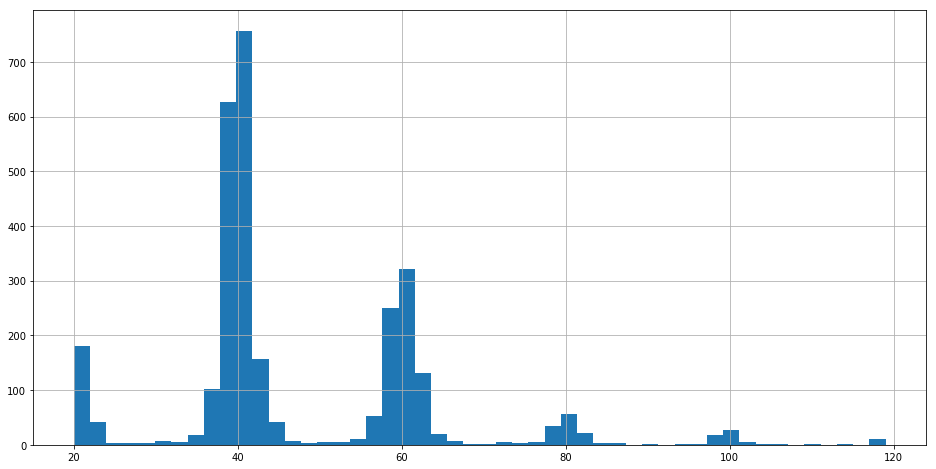

time: 221 ms


In [21]:
ssid_df.TravelTime.hist(figsize=(16, 8), bins=50)

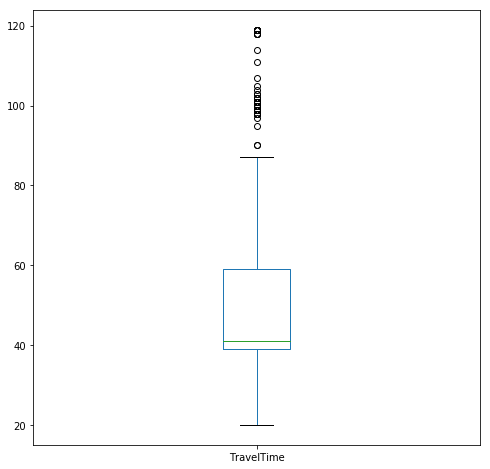

time: 128 ms


In [22]:
ssid_df.TravelTime.plot(kind='box', figsize=(8, 8), showfliers=True)

## 2. Visualising the data

### 2ai Bar plot for mean TravelTime per HourFrame

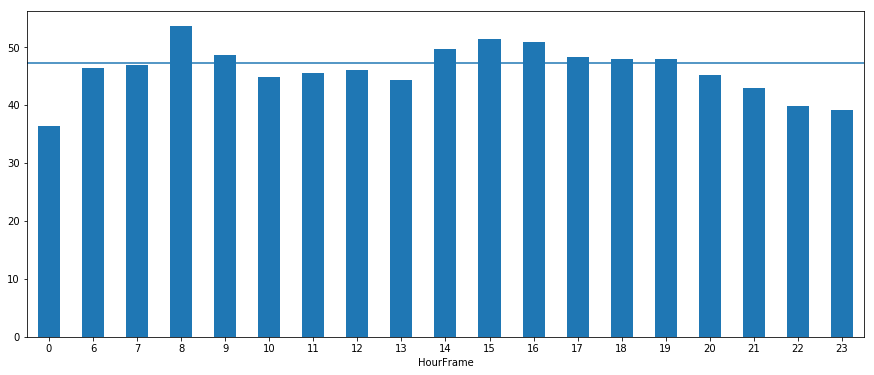

time: 182 ms


In [23]:
mean_HF = ssid_df.groupby('HourFrame')['TravelTime'].mean()
mean_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2aii Bar plot for median TravelTime per HourFrame

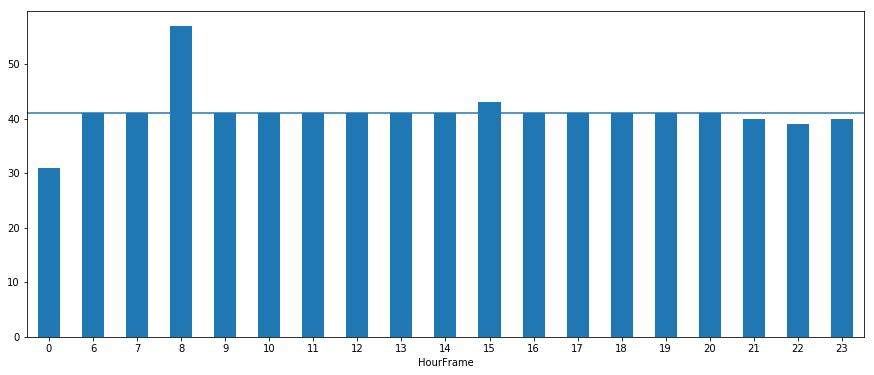

time: 186 ms


In [24]:
med_HF = ssid_df.groupby('HourFrame')['TravelTime'].median()
med_HF.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 25

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bi Bar plot for mean TravelTime per Day

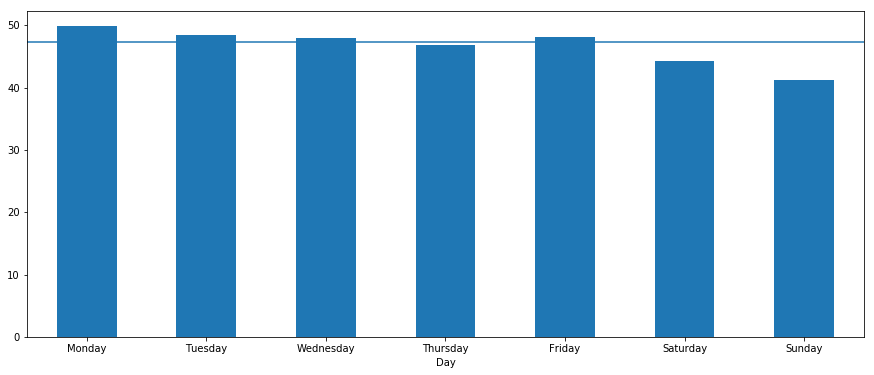

time: 141 ms


In [25]:
mean_Day = ssid_df.groupby('Day')['TravelTime'].mean()
mean_Day=mean_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

mean_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean

coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2bii Bar plot for median TravelTime per HourFrame

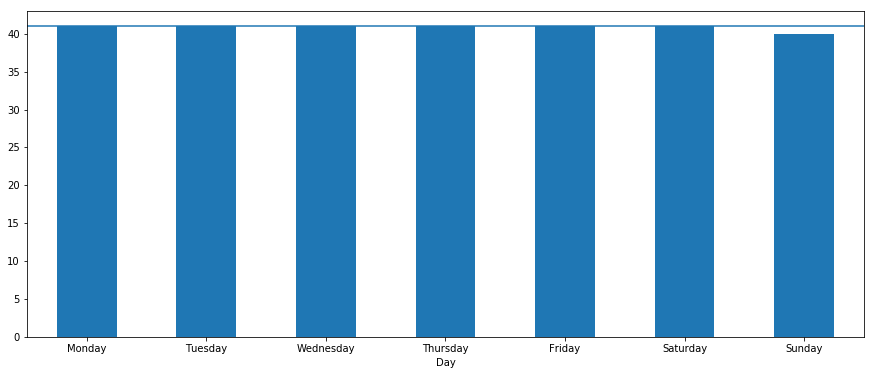

time: 182 ms


In [26]:
med_Day = ssid_df.groupby('Day')['TravelTime'].median()

med_Day=med_Day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
med_Day.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation: 

### 2ci Bar plot for mean TravelTime when SchoolHoliday true/false

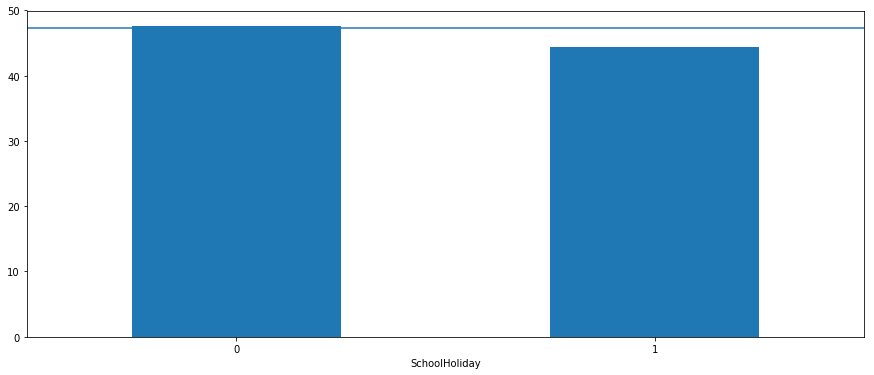

time: 122 ms


In [27]:
mean_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].mean()
mean_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_mean
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Observation:  

### 2cii Bar plot for median TravelTime when SchoolHoliday true/false

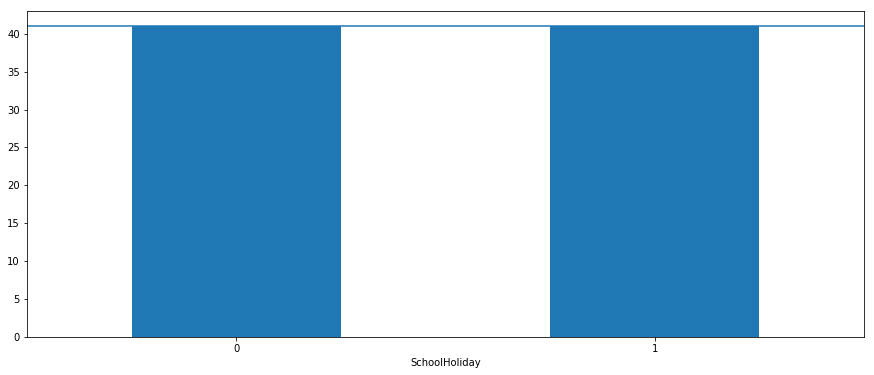

time: 132 ms


In [28]:
med_SH = ssid_df.groupby('SchoolHoliday')['TravelTime'].median()
med_SH.plot(kind='bar', figsize=(15, 6), rot=0)

coord_x1 = -1
coord_y1 = ssid_df_median
coord_x2 = 7

plt.plot([coord_x1, coord_x2], [coord_y1, coord_y1], '-o')

Splitting data into 70% for training and 30% for testing

## 3 Model training (Scikit-learn)

First we need to dreate dummy variables for categorical features, and split into test and training sets

### 3.1 Prepare data for modelling via Scikit-learn

In [29]:
# create dummy variables from HourFrame and Day using get_dummies
# dropping first values to avoid multicollinearity (Day = Friday, Hour = 0 or 6 or 7, depending on SSID)

Day_dummies = pd.get_dummies(ssid_df.Day, prefix='Day', drop_first=True)
HF_dummies = pd.get_dummies(ssid_df.HourFrame, prefix='HF', drop_first=True)

# concatenate the dummy variable columns onto the original DataFrame and drop the original features
ssid_df = pd.concat([ssid_df, HF_dummies, Day_dummies], axis=1)
ssid_df = ssid_df.drop(['HourFrame', 'Day'], axis=1)
ssid_df

,TravelTime,Rain,WindSpeed,JPID_length,SchoolHoliday,HF_6,HF_7,HF_8,HF_9,HF_10,...,HF_20,HF_21,HF_22,HF_23,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,119,0.000000,8.5,62,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,119,1.166667,15.5,86,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,119,0.000000,11.5,86,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,119,0.000000,13.0,62,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,119,0.000000,10.5,62,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
5,119,0.099976,9.0,62,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,119,0.000000,19.0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,118,0.000000,6.0,62,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
8,118,0.000000,15.5,44,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9,118,0.000000,14.0,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


time: 54 ms


In [30]:
# prepare a list containing all remaining features bar the target
pred_features = list(ssid_df)
pred_features.remove('TravelTime')
print(pred_features)

['Rain', 'WindSpeed', 'JPID_length', 'SchoolHoliday', 'HF_6', 'HF_7', 'HF_8', 'HF_9', 'HF_10', 'HF_11', 'HF_12', 'HF_13', 'HF_14', 'HF_15', 'HF_16', 'HF_17', 'HF_18', 'HF_19', 'HF_20', 'HF_21', 'HF_22', 'HF_23', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday']
time: 2 ms


In [31]:
# prepare target/predictive feature variables for use in scikit-learn modelling

X = ssid_df[pred_features]
y = ssid_df['TravelTime']

time: 3 ms


In [32]:
# split the data into training portion (70%) and final testing potion (30%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 38)

time: 4 ms


For comparison purposes, first train on Linear Regression

### 3.2a Linear Regression model (via scikit-learn) - training - default parameters

In [33]:
lr = LinR(n_jobs = cores)
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=3, normalize=False)

time: 73 ms


In [34]:

lr_pred = lr.predict(X_train)
lr_rsq = metrics.r2_score(y_train, lr_pred)
print ("The R-squared value of the Linear Regression model is", lr_rsq)
print()
lr_mae = metrics.mean_absolute_error(y_train, lr_pred)
print ("The mean absolute error of the Linear Regression model is", lr_mae)
print ("The mean absolute percentage error is", (((lr_mae)/ssid_df_mean)*100))
print()
lr_mdae = metrics.median_absolute_error(y_train, lr_pred)
print ("The median absolute error of the Linear Regression model is", lr_mdae)
print ("The median absolute percentage error is", (((lr_mdae)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.0639163301929

The mean absolute error of the Linear Regression model is 11.7787782934
The mean absolute percentage error is 24.9168238602

The median absolute error of the Linear Regression model is 9.37254747585
The median absolute percentage error is 22.8598718923
time: 9 ms


### 3.2b Linear Regression model (via scikit-learn) - testing - default parameters

In [35]:
lr_preda = lr.predict(X_test)
lr_rsqa = metrics.r2_score(y_test, lr_preda)
print ("The R-squared value of the Linear Regression model is", lr_rsqa)
print()
lr_maea = metrics.mean_absolute_error(y_test, lr_preda)
print ("The mean absolute error of the Linear Regression model is", lr_maea)
print ("The mean absolute percentage error is", (((lr_maea)/ssid_df_mean)*100))
print()
lr_mdaea = metrics.median_absolute_error(y_test, lr_preda)
print ("The median absolute error of the Linear Regression model is", lr_mdaea)
print ("The median absolute percentage error is", (((lr_mdaea)/ssid_df_median)*100))

The R-squared value of the Linear Regression model is 0.0635323153423

The mean absolute error of the Linear Regression model is 11.9964769741
The mean absolute percentage error is 25.3773435801

The median absolute error of the Linear Regression model is 9.04832477514
The median absolute percentage error is 22.0690848174
time: 12 ms


### 3.3a Gradient Boosting Regression model - training - default parameters

In [36]:
gbr = GBR()
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 104 ms


In [37]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.278084655099
Rain 	 0.124770999138
JPID_length 	 0.0905176706161
SchoolHoliday 	 0.0533679868985
Day_Sunday 	 0.0443929483102
Day_Saturday 	 0.0330815836876
HF_21 	 0.0310452550394
Day_Monday 	 0.0298343287989
HF_22 	 0.0292845313344
Day_Tuesday 	 0.0271489366216
HF_23 	 0.0271244927405
Day_Thursday 	 0.0266525939506
HF_16 	 0.025546366029
HF_15 	 0.0253361135865
HF_8 	 0.0234491178043
Day_Wednesday 	 0.0213346457228
HF_14 	 0.0209627486251
HF_12 	 0.0199687904066
HF_9 	 0.0185906587798
HF_7 	 0.0125131306724
HF_18 	 0.00871720406124
HF_13 	 0.00796574530296
HF_10 	 0.00751244925993
HF_17 	 0.00472260493623
HF_11 	 0.00444065791357
HF_20 	 0.00363378466407
HF_6 	 0.0
HF_19 	 0.0
time: 78 ms


In [38]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.164670412886

The mean absolute error of the trained Gradient Boosting Regression model is 11.153047734
The mean absolute percentage error is 23.5931536335

The median absolute error of the trained Gradient Boosting Regression model is 9.02495696737
The median absolute percentage error is 22.0120901643
time: 13 ms


### 3.3b Gradient Boosting Regression model - - testing - default parameters

In [39]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.0466767732681

The mean absolute error of the trained Gradient Boosting Regression model is 12.0524771121
The mean absolute percentage error is 25.4958062543

The median absolute error of the trained Gradient Boosting Regression model is 9.10295673206
The median absolute percentage error is 22.2023334928
time: 11 ms


### 3.4a Gradient Boosting Regression model - training - LAD loss function 

In [40]:
gbr = GBR(loss='lad')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

time: 198 ms


In [41]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.475737557793
Rain 	 0.127461170523
HF_10 	 0.112289190649
SchoolHoliday 	 0.0914341359678
HF_6 	 0.0771199649734
HF_8 	 0.0413434580437
HF_7 	 0.0189568852683
HF_22 	 0.0107450955283
Day_Saturday 	 0.00801249560328
Day_Monday 	 0.00518043133945
HF_16 	 0.00492017731636
HF_23 	 0.00462129220598
HF_14 	 0.00419197074651
Day_Wednesday 	 0.00351644989997
JPID_length 	 0.00258995560255
Day_Sunday 	 0.00249226919764
HF_20 	 0.0020036205238
HF_11 	 0.00158590176838
Day_Tuesday 	 0.0015287192087
HF_21 	 0.00151286757744
HF_15 	 0.00127661082638
HF_13 	 0.000742772952813
HF_19 	 0.00073700648398
HF_17 	 0.0
HF_12 	 0.0
HF_18 	 0.0
HF_9 	 0.0
Day_Thursday 	 0.0
time: 64 ms


In [42]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is -0.0927433836404

The mean absolute error of the trained Gradient Boosting Regression model is 10.5627297272
The mean absolute percentage error is 22.3443951094

The median absolute error of the trained Gradient Boosting Regression model is 3.90294535664
The median absolute percentage error is 9.51937891864
time: 11 ms


### 3.4b Gradient Boosting Regression model - testing - LAD loss function 

In [43]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is -0.0776986482433

The mean absolute error of the trained Gradient Boosting Regression model is 10.8485696246
The mean absolute percentage error is 22.9490607377

The median absolute error of the trained Gradient Boosting Regression model is 3.9
The median absolute percentage error is 9.51219512195
time: 10 ms


### 3.5a Gradient Boosting Regression model - training - HUBER loss function 

In [44]:
gbr = GBR(loss='huber')
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

time: 172 ms


In [45]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.278882290546
Rain 	 0.153980357244
JPID_length 	 0.0524092917917
Day_Sunday 	 0.0489098857486
SchoolHoliday 	 0.0466406216038
HF_22 	 0.0396845991253
Day_Wednesday 	 0.035564882348
HF_21 	 0.034850797842
Day_Saturday 	 0.0347412832765
HF_23 	 0.034212467848
HF_16 	 0.0278042112099
HF_7 	 0.0237993602393
HF_14 	 0.0233651221365
Day_Monday 	 0.0228618946884
HF_8 	 0.0207532839708
Day_Thursday 	 0.0205084529956
Day_Tuesday 	 0.0182959788882
HF_15 	 0.0181643014199
HF_10 	 0.0131347958063
HF_17 	 0.0129909150485
HF_11 	 0.0107049486676
HF_9 	 0.00997588607665
HF_12 	 0.00726251665693
HF_18 	 0.00395447611702
HF_13 	 0.0031934489306
HF_20 	 0.00204808672218
HF_19 	 0.00130584305101
HF_6 	 0.0
time: 66 ms


In [46]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.134046565154

The mean absolute error of the trained Gradient Boosting Regression model is 10.8599049061
The mean absolute percentage error is 22.9730393885

The median absolute error of the trained Gradient Boosting Regression model is 8.15215331117
The median absolute percentage error is 19.883300759
time: 11 ms


### 3.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [47]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.0579802536792

The mean absolute error of the trained Gradient Boosting Regression model is 11.6110049246
The mean absolute percentage error is 24.5619161291

The median absolute error of the trained Gradient Boosting Regression model is 8.51726435345
The median absolute percentage error is 20.7738154962
time: 10 ms


## 4 Parameter tuning with RandomizedSearchCV

In [48]:
print("Note that there are", JPID_Count, "unique JPIDs traversing this segment, over the course of", Row_Count, "observations.")

Note that there are 7 unique JPIDs traversing this segment, over the course of 2970 observations.
time: 2 ms


In [49]:
STOP HERE - from results above, select best loss function for each of the three trainings below,

SyntaxError: invalid syntax (<ipython-input-49-df044ab76723>, line 1)

### 4a Gradient Boosted Regression with RandomizedSearchCV (scikit), Kfold 5, 5 iterations

##### Train with Median Absolute Error as scorer

In [50]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [51]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.median_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020565F28>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000206FBEB8>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000203CD518>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000000203CD940>, 'learning_rate': <scipy.stats._distn_inf

time: 1min 33s


In [52]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.026551415869006847, 'max_depth': 4, 'min_samples_leaf': 18, 'min_samples_split': 745, 'n_estimators': 99}
time: 1e+03 µs


In [53]:
gbr_train_MdAE = abs(gbr_rsearch.best_score_)
gbr_train_MdAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best MdAE found is", gbr_train_MdAE)
print ("Best MdAPE found is", str(round(gbr_train_MdAPE, 3)) + "%")

Best MdAE found is 8.28086280934
Best MdAPE found is 20.197%
time: 6 ms


In [54]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-8.137390,-8.280863,99,4,18,745,0.0265514,0.1432,0.0010
1,2,-8.373698,-8.688545,113,4,96,506,0.112808,0.1706,0.0012
2,3,-8.479079,-8.751286,1188,3,75,566,0.0169484,1.4568,0.0056
3,4,-8.244675,-8.846950,748,7,92,933,0.0962087,1.0816,0.0048
4,5,-8.498014,-8.866313,282,4,17,606,0.0561664,0.4038,0.0018
5,6,-8.502403,-8.920699,106,3,64,208,0.263057,0.1336,0.0010
6,7,-8.315522,-8.933000,465,6,99,528,0.0638626,0.9870,0.0046
7,8,-8.338029,-8.959132,1239,6,11,898,0.0210005,2.3314,0.0096
8,9,-8.528369,-8.998601,178,4,64,557,0.100615,0.2578,0.0012
9,10,-8.254056,-9.020010,882,7,13,964,0.0448385,1.5414,0.0062


time: 32 ms


In [55]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0540467607694

Mean absolute error of best model on the test set is 11.5678420162
Mean absolute percentage error of best model on the test set is 28.214%

Median absolute error of best model on the test set is 7.81739897696
Median absolute percentage error of best model on the test set is 19.067%
time: 14 ms


##### Train with Mean Absolute Error as scorer

In [56]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 6 ms


In [57]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.mean_absolute_error, greater_is_better=False))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020723D68>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020723F60>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002075D0B8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000000002075D358>, 'learning_rate': <scipy.stats._distn_inf

time: 1min 28s


In [58]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.077562978318556297, 'max_depth': 7, 'min_samples_leaf': 68, 'min_samples_split': 880, 'n_estimators': 189}
time: 2 ms


In [59]:
gbr_train_MAE = abs(gbr_rsearch.best_score_)
gbr_train_MAPE = (gbr_train_MdAE/ssid_df_median)*100

print("Best Mean absolute error found is", gbr_train_MAE)
print ("Best Mean absolute percentage error found is", str(round(gbr_train_MAPE, 3)) + "%")

Best Mean absolute error found is 11.578743013
Best Mean absolute percentage error found is 20.197%
time: 3 ms


In [60]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,-11.045542,-11.578743,189,7,68,880,0.077563,0.3428,0.0018
1,2,-11.001000,-11.586821,944,3,64,714,0.0752726,1.1700,0.0044
2,3,-11.080864,-11.599148,468,9,96,576,0.0336072,1.0196,0.0044
3,4,-11.311038,-11.612726,368,3,93,252,0.0467249,0.4640,0.0020
4,5,-10.872367,-11.612729,184,6,76,470,0.12186,0.3866,0.0020
5,6,-11.266271,-11.614379,617,3,7,771,0.0181347,0.7034,0.0030
6,7,-11.465798,-11.617620,354,4,98,570,0.0119448,0.5220,0.0022
7,8,-10.819527,-11.628633,127,7,19,670,0.10821,0.2858,0.0018
8,9,-10.865811,-11.647605,267,4,96,778,0.274287,0.3800,0.0022
9,10,-10.672136,-11.651661,1260,6,90,381,0.0369607,2.7420,0.0118


time: 32 ms


In [61]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0724207615983

Mean absolute error of best model on the test set is 11.5133772841
Mean absolute percentage error of best model on the test set is 28.081%

Median absolute error of best model on the test set is 8.62298852673
Median absolute percentage error of best model on the test set is 21.032%
time: 16 ms


##### Train with R-squared value as scorer

In [62]:
gbr = GBR(loss='huber')

param_gbr = {'n_estimators': stats.randint(75, 1500),
            'max_depth': stats.randint(3, 10),
            'min_samples_leaf': stats.randint(5, 100),
            'min_samples_split': stats.randint(200, 1000),
            'learning_rate': stats.uniform(0.01, 0.3)}

time: 5 ms


In [63]:
gbr_rsearch = RSCV(gbr, param_distributions=param_gbr, n_iter=iters, cv=5, n_jobs=cores, scoring=make_scorer(metrics.r2_score))
gbr_rsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=38, n_jobs=3,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020779940>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020779B38>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020779BE0>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000000020783400>, 'learning_rate': <scipy.stats._distn_inf

time: 1min 44s


In [64]:
print("Best parameters set found:")
print(gbr_rsearch.best_params_)

Best parameters set found:
{'learning_rate': 0.036207054836950803, 'max_depth': 4, 'min_samples_leaf': 53, 'min_samples_split': 573, 'n_estimators': 370}
time: 1e+03 µs


In [65]:
gbr_train_rsqa = abs(gbr_rsearch.best_score_)

print("Best R-squared value found is", gbr_train_rsqa)

Best R-squared value found is 0.0311738502975
time: 1 ms


In [66]:
gbr_rsearch_table = pd.DataFrame(gbr_rsearch.cv_results_)
gbr_rsearch_table.sort_values(['rank_test_score'], inplace=True)
gbr_rsearch_table = gbr_rsearch_table[['rank_test_score', 'mean_train_score', 'mean_test_score', 'param_n_estimators', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_learning_rate', 'mean_fit_time', 'mean_score_time']]
gbr_rsearch_table.reset_index(inplace=True)
gbr_rsearch_table = gbr_rsearch_table.drop('index', axis=1)

print("Full ranked results for GBR RandomizedSearchCV:")
gbr_rsearch_table

Full ranked results for GBR RandomizedSearchCV:


,rank_test_score,mean_train_score,mean_test_score,param_n_estimators,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_learning_rate,mean_fit_time,mean_score_time
0,1,0.092360,0.031174,370,4,53,573,0.0362071,0.5474,0.0026
1,2,0.084281,0.029527,1210,3,19,512,0.0116012,1.4410,0.0052
2,3,0.083085,0.023916,168,4,78,441,0.0974849,0.2572,0.0012
3,4,0.106462,0.018690,1019,3,75,546,0.0589751,1.3116,0.0054
4,5,0.127254,0.018550,268,3,55,546,0.23321,0.3272,0.0020
5,6,0.099499,0.016754,532,6,96,986,0.0920565,0.8062,0.0034
6,7,0.114156,0.015780,480,5,90,878,0.103088,0.6954,0.0032
7,8,0.153348,0.014471,465,6,49,485,0.0596503,0.9728,0.0040
8,9,0.126885,0.013979,380,6,14,514,0.0384926,0.7502,0.0036
9,10,0.111381,0.011796,561,3,95,560,0.170494,0.6976,0.0034


time: 34 ms


In [67]:
# Running model on 30% test set

gbr_test_pred = gbr_rsearch.best_estimator_.predict(X_test)

gbr_test_rsqa = metrics.r2_score(y_test, gbr_test_pred)
gbr_test_MAE = metrics.mean_absolute_error(y_test, gbr_test_pred)
gbr_test_MAPE = (gbr_test_MAE/ssid_df_median)*100
gbr_test_MdAE = metrics.median_absolute_error(y_test, gbr_test_pred)
gbr_test_MdAPE = (gbr_test_MdAE/ssid_df_median)*100

print("R-squared value of best model on the test set is", gbr_test_rsqa)
print()
print("Mean absolute error of best model on the test set is", gbr_test_MAE)
print ("Mean absolute percentage error of best model on the test set is", str(round(gbr_test_MAPE, 3)) + "%")
print()
print("Median absolute error of best model on the test set is", gbr_test_MdAE)
print ("Median absolute percentage error of best model on the test set is", str(round(gbr_test_MdAPE, 3)) + "%")

R-squared value of best model on the test set is 0.0670096338741

Mean absolute error of best model on the test set is 11.5903779551
Mean absolute percentage error of best model on the test set is 28.269%

Median absolute error of best model on the test set is 8.55805491677
Median absolute percentage error of best model on the test set is 20.873%
time: 16 ms


### 4.5a Gradient Boosting Regression model - training - HUBER loss function new parameters

In [68]:
gbr = GBR(loss='huber', min_samples_split = int(Row_Count/100), min_samples_leaf=int(Row_Count/200), 
          learning_rate=0.1, n_estimators=300, max_depth=6, subsample=0.8)
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='huber', max_depth=6,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=14,
             min_samples_split=29, min_weight_fraction_leaf=0.0,
             n_estimators=300, presort='auto', random_state=None,
             subsample=0.8, verbose=0, warm_start=False)

time: 1.29 s


In [69]:
indices = np.argsort(gbr.feature_importances_)[::-1]

# Print the ordered feature ranking
print("Ordered feature ranking:")

for f in range(X_train.shape[1]):
    feat = indices[f]
    print(X_train.columns[feat], "\t", gbr.feature_importances_[indices[f]])

Ordered feature ranking:
WindSpeed 	 0.412185418951
Rain 	 0.131273298735
JPID_length 	 0.1181292413
Day_Tuesday 	 0.0274253406866
Day_Thursday 	 0.0218868010965
Day_Wednesday 	 0.0200940420523
Day_Monday 	 0.0189108258423
HF_8 	 0.018235571744
SchoolHoliday 	 0.0155901363413
HF_9 	 0.0153336618634
HF_16 	 0.0151258135139
HF_7 	 0.0148924953695
HF_15 	 0.0147748371322
Day_Saturday 	 0.0146631218056
HF_18 	 0.0140447063371
Day_Sunday 	 0.0137476615181
HF_14 	 0.0134616595147
HF_22 	 0.0130829000392
HF_12 	 0.0113974745657
HF_19 	 0.0113583583206
HF_20 	 0.0102936992616
HF_23 	 0.00994187884894
HF_10 	 0.00983569177967
HF_21 	 0.00979498836808
HF_11 	 0.00930929783475
HF_17 	 0.00922626190362
HF_13 	 0.00598481527481
HF_6 	 0.0
time: 178 ms


In [70]:
gbr_pred = gbr.predict(X_train)
gbr_rsq = metrics.r2_score(y_train, gbr_pred)
gbr_mae = metrics.mean_absolute_error(y_train, gbr_pred)
gbr_mdae = metrics.median_absolute_error(y_train, gbr_pred)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsq)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_mae)
print ("The mean absolute percentage error is", (((gbr_mae)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdae)
print ("The median absolute percentage error is", (((gbr_mdae)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.317006034986

The mean absolute error of the trained Gradient Boosting Regression model is 9.30615290066
The mean absolute percentage error is 19.6862328898

The median absolute error of the trained Gradient Boosting Regression model is 7.23348713084
The median absolute percentage error is 17.6426515386
time: 25 ms


### 4.5b Gradient Boosting Regression model - testing - HUBER loss function 

In [71]:
gbr_preda = gbr.predict(X_test)
gbr_rsqa = metrics.r2_score(y_test, gbr_preda)
gbr_maea = metrics.mean_absolute_error(y_test, gbr_preda)
gbr_mdaea = metrics.median_absolute_error(y_test, gbr_preda)
print ("The R-squared value of the trained Gradient Boosting Regression model is", gbr_rsqa)
print ()
print ("The mean absolute error of the trained Gradient Boosting Regression model is", gbr_maea)
print ("The mean absolute percentage error is", (((gbr_maea)/ssid_df_mean)*100))
print ()
print ("The median absolute error of the trained Gradient Boosting Regression model is", gbr_mdaea)
print ("The median absolute percentage error is", (((gbr_mdaea)/ssid_df_median)*100))

The R-squared value of the trained Gradient Boosting Regression model is 0.00845063333028

The mean absolute error of the trained Gradient Boosting Regression model is 11.9184610553
The mean absolute percentage error is 25.2123087304

The median absolute error of the trained Gradient Boosting Regression model is 8.9481245606
The median absolute percentage error is 21.8246940502
time: 15 ms
